# **Credit Card Fraud Detection Using Machine Learning**

# **Objective:** To detect fraudulent credit card transactions using both anomaly detection methods and a supervised XGBoost classifier, and to deploy the model as an interactive web app

In [1]:
#Set Up the Environment
pip install pandas scikit-learn xgboost matplotlib seaborn streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 483.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [2]:
#Load and Explore the Data
import pandas as pd

df = pd.read_csv('creditcard.csv')
print(df.shape)
print(df.head())
print(df['Class'].value_counts())  # 0 = normal, 1 = fraud


(221880, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

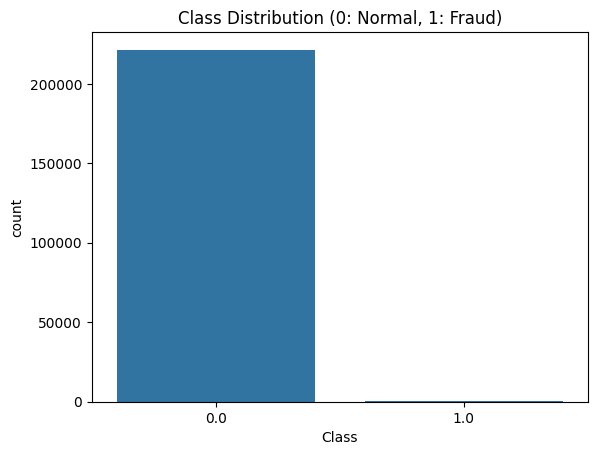

In [3]:
#Visualize Class Imbalance
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Class')
plt.title("Class Distribution (0: Normal, 1: Fraud)")
plt.show()


In [4]:
#Anomaly Detection
# Isolation Forest
from sklearn.ensemble import IsolationForest

X = df.drop(columns=['Class'])
iso = IsolationForest(contamination=0.0017, random_state=42)
df['IF_Pred'] = (iso.fit_predict(X) == -1).astype(int)


In [5]:
#Local Outlier Factor (on a small sample)
from sklearn.neighbors import LocalOutlierFactor

df_sample = df.sample(n=10000, random_state=42)
X_sample = df_sample.drop(columns=['Class'])

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
df_sample['LOF_Pred'] = (lof.fit_predict(X_sample) == -1).astype(int)


In [6]:
#Handle Class Imbalance (Under-sampling)
from sklearn.utils import resample

fraud = df[df.Class == 1]
normal = df[df.Class == 0]

normal_downsampled = resample(normal, n_samples=len(fraud), replace=False, random_state=42)
df_balanced = pd.concat([fraud, normal_downsampled]).sample(frac=1, random_state=42)


In [7]:
# Train XGBoost Classifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df_balanced.drop(columns=['Class'])
y = df_balanced['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:05:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[80  2]
 [ 8 74]]
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94        82
         1.0       0.97      0.90      0.94        82

    accuracy                           0.94       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.94      0.94      0.94       164



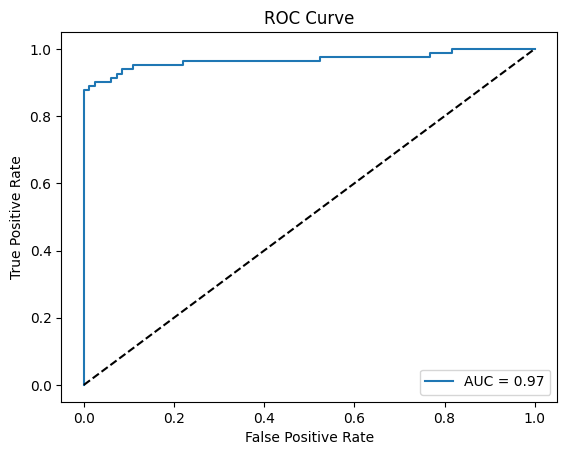

In [8]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
